In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import json
import time
import pytensor 
import pymc as pm
import arviz as az
import jax
import jax.numpy as jnp
import pyhf
import scipy.stats as sps
pyhf.set_backend('jax')

from jax import grad, jit, vmap, value_and_grad, random
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
from pytensor.graph import Apply, Op


import external4

from contextlib import contextmanager

## Model

In [2]:
### Simple pyhf model
dummy_model = pyhf.Model(
    {'channels': [{'name': 'singlechannel',
    'samples': [
    {'name': 'signal',
     'data': [6, 6, 3],
     'modifiers': [
         {'name': 'mu', 'type': 'normfactor', 'data': None}]},

    {'name': 'background',
     'data': [55, 55, 55],''
     'modifiers': [
        ## Staterror / Normal
        {"name": "my_staterror","type": "staterror","data": [2.0, 2.0, 2.4],},
        ## Lumi / Normal
        {'name': 'lumi', 'type': 'lumi', 'data': None},
        ## Correlated / Normal
        {'name': 'corr_bkg', 'type': 'histosys','data': {'hi_data': [65, 56, 67], 'lo_data': [40, 40, 43]}},
        {'name': 'corr_bkg1', 'type': 'histosys','data': {'hi_data': [65, 65, 66], 'lo_data': [40, 40, 40]}},
        {'name': 'corr_bkg2', 'type': 'histosys','data': {'hi_data': [66, 65, 60], 'lo_data': [40, 40, 39]}},
        ## Uncorrelated / Poisson
        {'name': 'uncorr_bkg', 'type': 'shapesys','data': [7, 8, 7.17]},
        {'name': 'uncorr_bkg1', 'type': 'shapesys','data': [7, 8, 6.7]},
        {'name': 'uncorr_bkg2', 'type': 'shapesys','data': [7.27, 9, 7]},
        
         ]},    
                                 
    ]},
    ],
    "parameters": [
            {
                "name": "lumi",
                "auxdata": [1.0],
                "sigmas": [0.017],
                "bounds": [[0.915, 1.085]],
                "inits": [1.0],
            }
        ],}
)

dummy_nBins = len(dummy_model.expected_actualdata(dummy_model.config.suggested_init()))

### Observations
dummy_obs = dummy_model.expected_actualdata(dummy_model.config.suggested_init())

In [3]:
with open('SRee_SRmm_Srem.json') as serialized:
    spec = json.load(serialized)

workspace = pyhf.Workspace(spec)
DL_model = workspace.model()
DL_obs = workspace.data(DL_model, include_auxdata=False)
DL_nBins = len(DL_model.expected_actualdata(DL_model.config.suggested_init()))

In [4]:
with open('ttbar_ljets_xsec_inclusive_pruned.json') as serialized:
    spec = json.load(serialized)

workspace = pyhf.Workspace(spec)
ttbar_model = workspace.model()
ttbar_obs = workspace.data(ttbar_model, include_auxdata=False)
ttbar_nBins = len(DL_model.expected_actualdata(ttbar_model.config.suggested_init()))

## Sampling with external4.py

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [Unconstrained]
>Metropolis: [Normals]
>Metropolis: [Gammas]
CompoundStep
>Metropolis: [Unconstrained]
>Metropolis: [Normals]
>Metropolis: [Gammas]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


Sampling: [Gammas, Normals, Unconstrained, main]


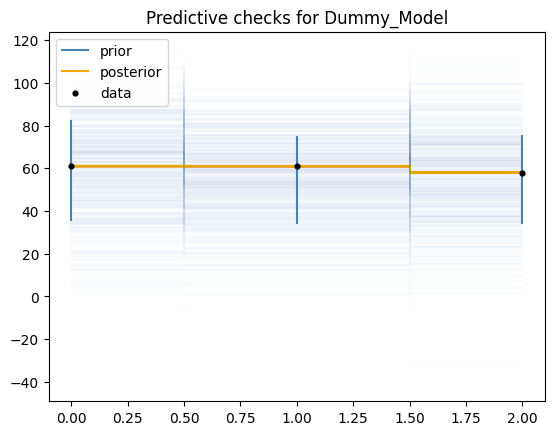

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [Unconstrained]
>Metropolis: [Normals]
CompoundStep
>Metropolis: [Unconstrained]
>Metropolis: [Normals]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


Sampling: [Normals, Unconstrained, main]


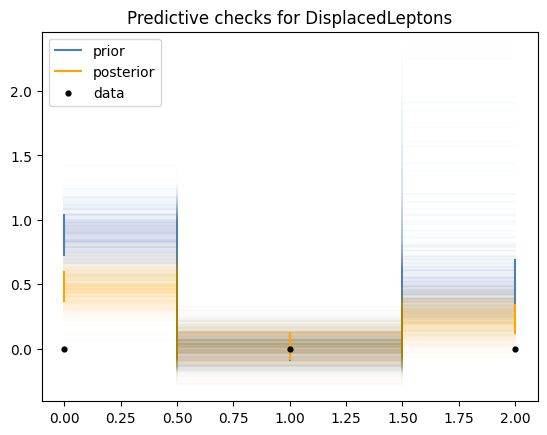

In [4]:
# list with all models
all_models = [['Dummy_Model', dummy_model, dummy_obs, dummy_nBins],     
              ['DisplacedLeptons', DL_model, DL_obs, DL_nBins]]#, 
            #   ['ttbar', ttbar_model, ttbar_obs, ttbar_nBins]]

for name, model, obs, nBins in all_models:
    # Supply information on the unconstrained parameters
    unconstr_dict = {
    'uncon1': {'type': 'unconstrained', 'type2': 'normal', 'input': [[1], [0.1]]}
    }

    # Create dictionary with all priors (unconstrained, constrained by normal and poisson)
    prior_dict = external4.prepare_priors(model, unconstr_dict)

    # dictionary with keys 'model', 'obs', 'priors', 'precision'
    prepared_model = external4.prepare_model(model=model, observations=obs, precision=0.10, priors=prior_dict)

    # sample
    post_data, post_pred, prior_pred = external4.sampling(prepared_model, 500)

    # plot
    external4.plot_ppc(model, name, obs, post_pred=post_pred, prior_pred=prior_pred)